# Decompose velocities into large-scale and mesoscale.

In order to decompose EKE into large scale and mesoscale. We first filtered the velocity fields into large-scale and mesoscale features. Then the EKE is computed for both scales. The following code shows how to reproduce it for the year 1993, but it can be extended to the full record by uncommenting cells. 

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
# Inline plotting
%matplotlib inline

In [2]:
from dask.distributed import Client

In [3]:
from utils import area,ccrs_land,add_patches

In [4]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:56851 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [5]:
from astropy import convolution

In [ ]:
inputfiles='path2AVISO+/*.nc'

In [6]:
dataset_AVISO = xr.open_dataset(inputfiles,chunks={'lat':10,'lon':10})

In [7]:
dataset_AVISO

,Array,Chunk
Bytes,2.56 GB,3.94 MB
Shape,"(9861, 180, 360)","(9861, 10, 10)"
Count,649 Tasks,648 Chunks
Type,float32,numpy.ndarray


# Large scale SST

In [8]:
ini = 1993
end = 1994
# Uncoment line below to reproduce large-scale SST over the full record
# end = 2019
for year in range(ini,end):
    print(year)
    kernel=np.ones((1,13,13))
    u_data = dataset_AVISO.ugosa.sel(time=str(year)).squeeze()
    v_data = dataset_AVISO.vgosa.sel(time=str(year)).squeeze()
    convolve_u = u_data.copy()
    convolve_v = v_data.copy()
    
    convolve_u.data = convolution.convolve(u_data,boundary='wrap', kernel = kernel, preserve_nan=True)
    convolve_v.data = convolution.convolve(v_data,boundary='wrap', kernel = kernel, preserve_nan=True)
    
    convolve_u.to_netcdf('../datasets/u_fitered_5deg_{0}.nc'.format(year))
    convolve_v.to_netcdf('../datasets/v_fitered_5deg_{0}.nc'.format(year))

1993


In [9]:
filtered_u = xr.open_mfdataset('../datasets/u_fitered_3deg_*.nc',chunks={'longitude':10,'latitude':10})
filtered_v = xr.open_mfdataset('../datasets/v_fitered_3deg_*.nc',chunks={'longitude':10,'latitude':10})

In [ ]:
rho=1025 # kg/m3
large_scale_EKE = 1/2 * rho * (filtered_u.ugosa**2 + filtered_v.vgosa**2)

In [10]:
ini = 1993
end = 1994
# Uncoment line below to reproduce large-scale SST over the full record
# end = 2019
for year in range(ini,end):
    print(year)
    u_data = dataset_AVISO.ugosa.sel(time=str(year)).squeeze()
    v_data = dataset_AVISO.vgosa.sel(time=str(year)).squeeze()
    u_mesoscale = u_data - filtered_u.sel(time=str(year)).squeeze()
    v_mesoscale = v_data - filtered_v.sel(time=str(year)).squeeze()

    u_mesoscale.to_netcdf('../datasets/u_mesoscale_3deg_{0}.nc'.format(year))
    v_mesoscale.to_netcdf('../datasets/v_mesoscale_3deg_{0}.nc'.format(year))

In [11]:
rho=1025 # kg/m3
mesoscale_EKE = 1/2 * rho * (filtered_u.ugosa**2 + filtered_v.vgosa**2)

In [ ]:
mean_large_scale_EKE = large_scale_EKE.mean("time")
mean_mesoscale_EKE = mesoscale_EKE.mean("time")

### Plot mean large-scale and mesoscale EKE.

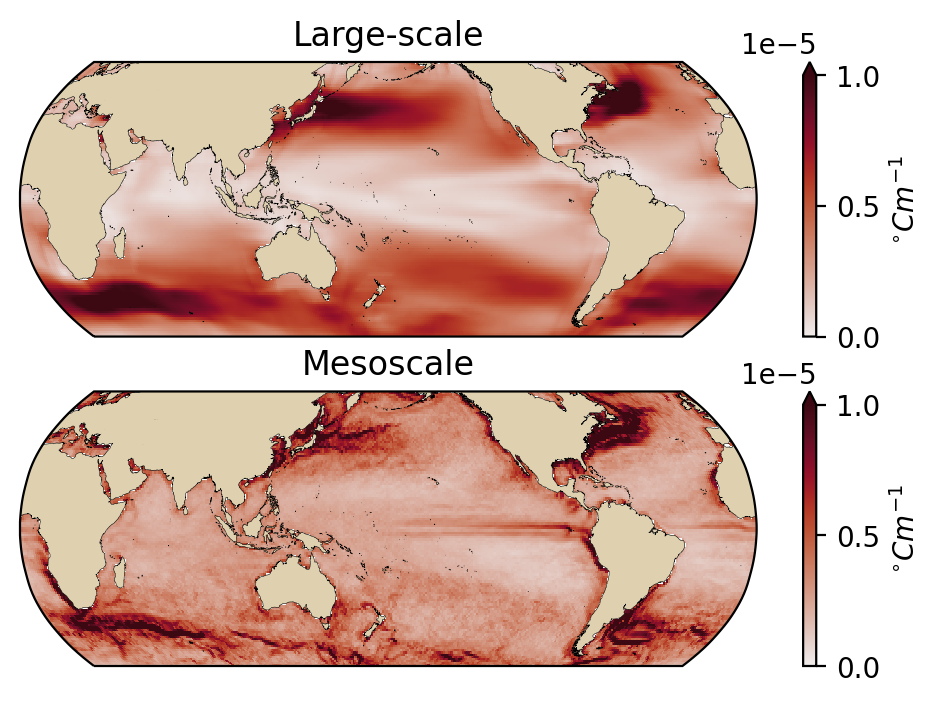

In [51]:
fig = plt.figure(figsize=(6,4), dpi=200)
ax = fig.add_subplot(2, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = mean_large_scale_EKE.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$^{\circ}C m^{-1}$"),
              cmap=cm.cm.amp, vmin=0, vmax=1e-5,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
ax.set_title('Large-scale')
add_patches(ax)

ax = fig.add_subplot(2, 1, 2, projection = ccrs.Robinson(central_longitude=180))

im = mean_mesoscale_EKE.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$^{\circ}C m^{-1}$"),
              cmap=cm.cm.amp, vmin=0, vmax=1e-5,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
ax.set_title('Mesoscale')
add_patches(ax)